###Install Split Folders

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Library

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

### **Load Dataset dan Splitting**
Split dataset into menjadi 2 bagian: Training set(80%) dan Test set(20%).

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nadhirdhanu","key":"ddea3ee6c54fd7e26ea181289de0b129"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [6]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset --force

 97% 213M/219M [00:01<00:00, 162MB/s]
100% 219M/219M [00:01<00:00, 132MB/s]


In [7]:
!unzip -FF 'rice-image-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [8]:
!ls /content/Rice_Image_Dataset

Arborio  Basmati  Ipsala  Jasmine  Karacadag  Rice_Citation_Request.txt


In [9]:
base_ds = '/content/Rice_Image_Dataset/'
base_ds = pathlib.Path(base_ds)

In [10]:
splitfolders.ratio(base_ds, output='imgs', seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 75000 files [00:09, 7669.58 files/s]


In [11]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

### **Data Pre-processing**

In [12]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 )

In [13]:
batch_size = 512
img_height, img_width = 96, 96
input_shape = (img_height, img_width, 3)

In [14]:
train_ds = datagen.flow_from_directory(
    #'imgs/train',
    base_ds,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    #'imgs/val',
    base_ds,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "validation",
    class_mode='categorical')
    #shuffle=False)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [15]:
#@title plot_train_history(history)
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### **Model Sequential**

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(2,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Conv2D(32,(2,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    #tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.Conv2D(64,(2,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Conv2D(64,(2,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 94, 32)        608       
                                                                 
 batch_normalization (BatchN  (None, 95, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 47, 32)        6176      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 47, 32)       128       
 hNormalization)                                                 
                                                        

### **Callbacks**

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

### **Run the model**

In [18]:
history = model.fit(train_ds, 
                    epochs = 40, 
                    steps_per_epoch = train_ds.samples // batch_size,
                    validation_data = val_ds, 
                    validation_steps = val_ds.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/40
117/117 [==============================] - 234s 2s/step - loss: 0.7209 - accuracy: 0.6991 - val_loss: 8.4146 - val_accuracy: 0.2000
Epoch 2/40
117/117 [==============================] - 216s 2s/step - loss: 0.2574 - accuracy: 0.9065 - val_loss: 8.8726 - val_accuracy: 0.1996
Epoch 3/40
117/117 [==============================] - 214s 2s/step - loss: 0.1235 - accuracy: 0.9579 - val_loss: 6.8734 - val_accuracy: 0.3538
Epoch 4/40
117/117 [==============================] - 214s 2s/step - loss: 0.0896 - accuracy: 0.9707 - val_loss: 5.3044 - val_accuracy: 0.2763
Epoch 5/40
117/117 [==============================] - 215s 2s/step - loss: 0.0765 - accuracy: 0.9752 - val_loss: 4.4663 - val_accuracy: 0.5440
Epoch 6/40
117/117 [==============================] - 214s 2s/step - loss: 0.0654 - accuracy: 0.9791 - val_loss: 2.2398 - val_accuracy: 0.7134
Epoch 7/40
117/117 [==============================] - 213s 2s/step - loss: 0.0550 - accuracy: 0.9820 - val_loss: 0.6918 - val_accuracy: 0.8652

### **Create Plot for Accuracy and Loss Model**

Accuracy

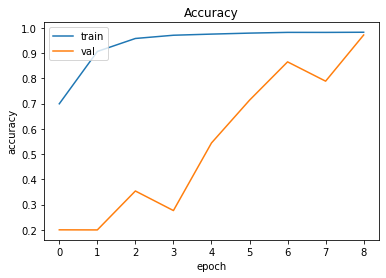

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss

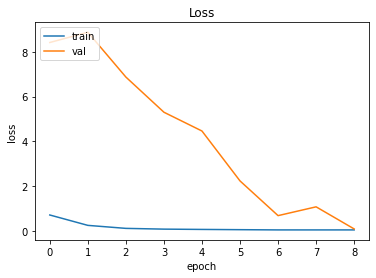

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Save Model to TF-Lite format**

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [22]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root   2785192 Dec 16 06:17 model.tflite
